# TSP LP : US 48 CITIES

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
seed = 42
np.random.seed(seed=seed)
%matplotlib inline
import pandas as pd

### Read data and parameters

In [121]:
data = pd.read_csv('att48.tsp', header=5)
df = data['NODE_COORD_SECTION'].str.split(' ', expand=True)
X = df[1].values[:-1].astype('int32')
Y = df[2].values[:-1].astype('int32')
XY = X + Y * 1j
num = len(X)

### Plot function with Optimal tour data

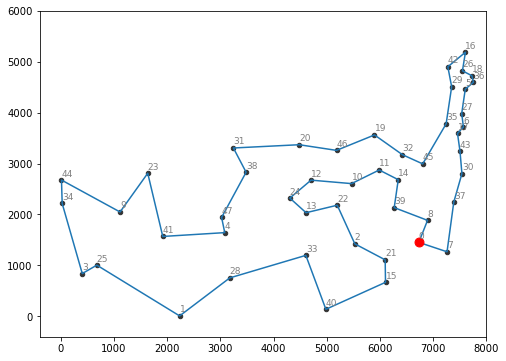

In [122]:
def draw_plot(T=False, E=False, E2=False, R=False, RM=False, MM=False, TX=True, size=(8, 6)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax.axis([-400, 8000, -400, 6000])
    cmap = plt.get_cmap("tab10")
    if MM:
        for n, m in enumerate(MM):
            for i in range(num):
                C = plt.Circle((X[i],Y[i]), m[i], fc=cmap(n%10), ec=None, fill=1, alpha=0.8, zorder=-n)
                ax.add_patch(C)
    if RM:
        for i in range(num):
            CM = plt.Circle((X[i],Y[i]), RM[i], fc='#6666cc', ec=None, fill=1, alpha=0.8, zorder=0)
            ax.add_patch(CM)
    
    if R:
        for i in range(num):
            C = plt.Circle((X[i],Y[i]), R[i], fc='#ffaaaa', ec=None, fill=1, alpha=0.8, zorder=1)
            ax.add_patch(C)
    
    if T:
        ax.plot(X[T], Y[T])
        
    ax.scatter(X, Y, s=20, color='#333333', marker='o', zorder=2)
    ax.scatter(X[0], Y[0], s=80, color='r', marker='o', zorder=3)
    
    if E:
        for e in E:
            ax.plot([X[e[0]], X[e[1]]], [Y[e[0]], Y[e[1]]], color='#888888')
    if E2:
        for e in E2:
            ax.plot([X[e[0]], X[e[1]]], [Y[e[0]], Y[e[1]]], color='#FF0000')
    if TX:
        for i in range(num):
            ax.text(X[i], Y[i]+80, s=i, fontsize=9, color='gray')

T_opt = pd.read_table('att48.opt.tour', header=4)
T_opt = list(T_opt.values[:-2, 0].astype('int32') - 1) + [0]
draw_plot(T_opt)

# LP :  case one
### Base constraints

Optimal


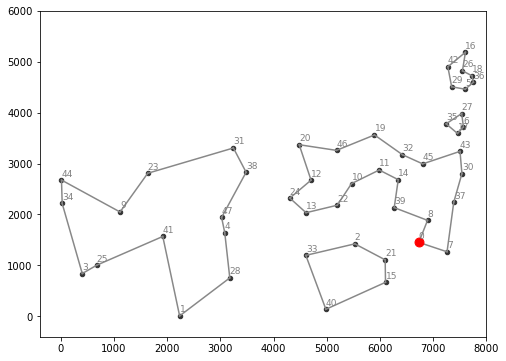

In [24]:
prob = LpProblem(name='TSP_LP', sense=LpMinimize)

dist = {(i, j): abs(XY[i] - XY[j]) for i in range(num) for j in range(num) if i < j}
x = LpVariable.dicts('x', dist, 0, 1, LpBinary)

prob += lpSum([dist[(i, j)] * x[(i, j)] for i, j in dist])

for n in range(num):
    prob += lpSum([x[(i, j)] for i, j in dist if n in (i, j)]) == 2
    
result = prob.solve()
print(LpStatus[result])

ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
draw_plot(False, ED)

### Find subtours

In [25]:
# Edge Grouping: return ST 
def find_subtour(ED):
    EG = []
    for e in ED:
        st = [e]
        while True:
            tmp = st.copy()
            for ee in ED:
                if set(sum(st, ())) & set(ee) and ee not in st:
                    st += [ee]
            if tmp == st:
                break
        if sorted(st) not in EG:
            EG.append(sorted(st))

    ST = []
    for i in range(num):
        for e in EG:
            if i == len(e):
                ST.append(e)
    return ST

ST = find_subtour(ED)
for st in ST:
    print(len(st), st)

4 [(6, 17), (6, 27), (17, 35), (27, 35)]
5 [(2, 21), (2, 33), (15, 21), (15, 40), (33, 40)]
7 [(5, 29), (5, 36), (16, 26), (16, 42), (18, 26), (18, 36), (29, 42)]
13 [(1, 28), (1, 41), (3, 25), (3, 34), (4, 28), (4, 47), (9, 23), (9, 44), (23, 31), (25, 41), (31, 38), (34, 44), (38, 47)]
19 [(0, 7), (0, 8), (7, 37), (8, 39), (10, 11), (10, 22), (11, 14), (12, 20), (12, 24), (13, 22), (13, 24), (14, 39), (19, 32), (19, 46), (20, 46), (30, 37), (30, 43), (32, 45), (43, 45)]


### Subtour elimination constraints loop

In [26]:
while len(ST) > 1:
    st = set(sum(ST[0], ()))
    print('ST[0]:', ST[0])
    nots = [n for n in range(num) if n not in st]
    prob += lpSum([x[(i, j)] for (i, j) in dist if (i in st and j in nots) or (i in nots and j in st)]) >= 2
    prob.solve()
    ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
    ST = find_subtour(ED)
    #draw_plot(False, ED)
    #plt.show()
    
print('Loop End')

ST[0]: [(6, 17), (6, 27), (17, 35), (27, 35)]
ST[0]: [(2, 21), (2, 33), (15, 21), (15, 40), (33, 40)]
ST[0]: [(5, 29), (5, 36), (16, 26), (16, 42), (18, 26), (18, 36), (29, 42)]
ST[0]: [(6, 17), (6, 35), (17, 35)]
ST[0]: [(5, 27), (5, 36), (6, 17), (6, 27), (16, 26), (16, 42), (17, 35), (18, 26), (18, 36), (29, 35), (29, 42)]
ST[0]: [(5, 27), (5, 36), (16, 26), (16, 42), (18, 26), (18, 36), (27, 29), (29, 42)]
ST[0]: [(6, 17), (6, 43), (17, 43)]
ST[0]: [(1, 28), (1, 41), (3, 25), (3, 34), (4, 28), (4, 47), (9, 23), (9, 44), (23, 31), (25, 41), (31, 38), (34, 44), (38, 47)]
ST[0]: [(20, 31), (20, 38), (31, 38)]
ST[0]: [(1, 28), (1, 41), (4, 28), (4, 47), (41, 47)]
ST[0]: [(1, 25), (1, 28), (3, 25), (3, 34), (4, 28), (4, 47), (9, 23), (9, 44), (23, 41), (34, 44), (41, 47)]
ST[0]: [(12, 13), (12, 24), (13, 24)]
ST[0]: [(2, 15), (2, 21), (15, 21)]
ST[0]: [(3, 25), (3, 34), (9, 23), (9, 25), (23, 44), (34, 44)]
ST[0]: [(1, 25), (1, 28), (2, 21), (2, 22), (3, 25), (3, 34), (4, 41), (4, 47), 

### Generate tour

Tour: [0, 7, 37, 30, 43, 17, 6, 27, 5, 36, 18, 26, 16, 42, 29, 35, 45, 32, 19, 46, 20, 31, 38, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 33, 40, 15, 21, 2, 22, 13, 24, 12, 10, 11, 14, 39, 8, 0]


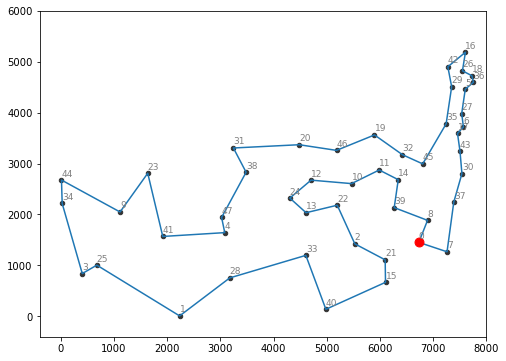

In [27]:
T = list(ED[0])
while len(T) < num:
    for (i, j) in ED:
        if i == T[-1] and j not in T:
            T.append(j)
        elif i not in T and j == T[-1]:
            T.append(i)

T += [T[0]]
print('Tour:', T)
draw_plot(T)

In [159]:
score(T)

33523.70850743559

# LP: case two
### Base constraints

Optimal


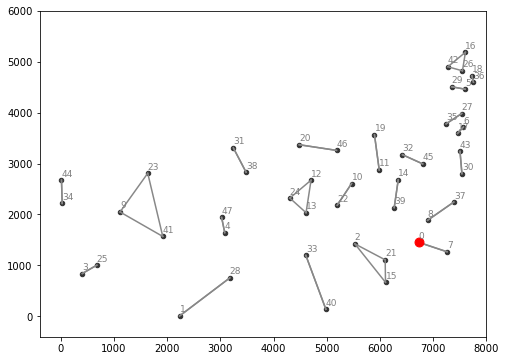

In [10]:
prob = LpProblem(name='TSP_LP', sense=LpMinimize)

dist = {(i, j): abs(XY[i] - XY[j]) for i in range(num) for j in range(num) if i != j}
x = LpVariable.dicts('x', dist, 0, 1, LpBinary)

prob += lpSum([dist[(i, j)] * x[(i, j)] for i, j in dist])

for n in range(num):
    prob += lpSum([x[(i, j)] for i, j in dist if n in (i, j)]) == 2
    
res = prob.solve()
print(LpStatus[res])

ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
draw_plot(False, ED)

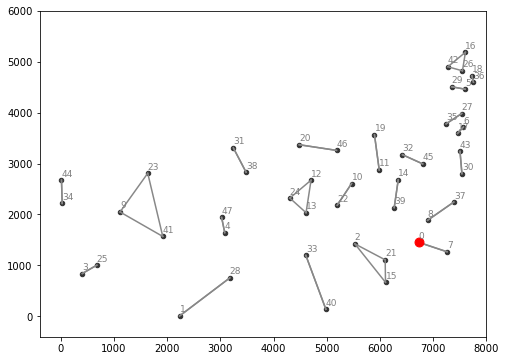

In [11]:
# single loop
for st in ST:
    st_flat = set(sum(st, ()))
    if len(st_flat) < num / 2:
        nots = [n for n in range(num) if n not in st_flat]
        prob += lpSum([x[(i, j)] for (i, j) in dist if (i in st_flat and j in nots) or (i in nots and j in st_flat)]) >= 2
        
prob.solve()        
ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
ST = find_subtour(ED)
draw_plot(False, ED)

{0, 7}
{1, 28}
{25, 3}
{4, 47}
{29, 5}
{17, 6}
{8, 37}
{10, 22}
{19, 11}
{14, 39}
{18, 36}
{20, 46}
{35, 27}
{43, 30}
{38, 31}
{32, 45}
{40, 33}
{34, 44}
{9, 41, 23}
{24, 12, 13}
{2, 21, 15}
{16, 26, 42}
{24, 13}
{21, 15}
{17, 43}
{37, 30}
{0, 8, 7}
{40, 33, 2}
{35, 27, 6}
{36, 5, 42, 16, 18, 26, 29}
{32, 39, 10, 11, 12, 45, 14, 46, 19, 20, 22}
{1, 34, 3, 4, 38, 41, 9, 44, 47, 23, 25, 28, 31}
{9, 23}
{17, 35, 6}
{25, 34, 3, 44}
{1, 4, 41, 47, 28}
{33, 2, 40, 15, 21}
{36, 5, 42, 16, 18, 26, 27, 29}
{0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 22, 24, 30, 31, 32, 37, 38, 39, 43, 45, 46}
{20, 38, 31}
{1, 34, 3, 4, 9, 41, 44, 47, 23, 25, 28}
{35, 36, 5, 6, 42, 16, 17, 18, 26, 27, 29}
{0, 2, 7, 8, 10, 11, 12, 13, 14, 15, 19, 21, 22, 24, 30, 32, 33, 37, 39, 40, 43, 45, 46}
{11, 14}
{17, 43, 6}
{34, 3, 9, 44, 23, 25}
{35, 36, 5, 42, 16, 18, 26, 27, 29}
{0, 1, 2, 4, 7, 8, 10, 12, 13, 15, 19, 20, 21, 22, 24, 28, 30, 31, 32, 33, 37, 38, 39, 40, 41, 45, 46, 47}
{1, 2, 3, 4, 9, 12, 13, 15, 20, 21, 22, 23

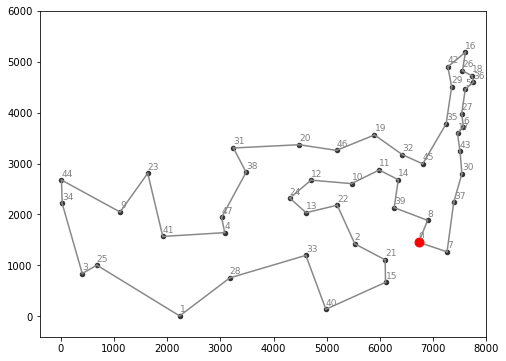

In [12]:
ST = find_subtour(ED)

while len(ST) > 1:
    for st in ST:
        st_flat = set(sum(st, ()))
        print(st_flat)
        if len(st_flat) < num / 2:
            nots = [n for n in range(num) if n not in st_flat]
            prob += lpSum([x[(i, j)] for (i, j) in dist if (i in st_flat and j in nots) or (i in nots and j in st_flat)]) >= 2
            prob.solve()
            ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
            ST = find_subtour(ED)

draw_plot(False, ED)

# Multi 2-opt

In [157]:
path = list(range(num))

def score(path):
    return sum(abs(XY[path[:-1]] - XY[path[1:]]))

def swap(path, i, j):
    pcopy = path.copy()
    pcopy = pcopy[:i] + pcopy[i:j][::-1] + pcopy[j:]
    sc = score(pcopy + [pcopy[0]])
    s = score(path + [path[0]])
    if sc < s:
        return pcopy
    else:
        return path

def two_opt_loop(path):
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            path = swap(path, i, j)
    print(score(path + [path[0]]))
    return path

34561.90133962142
34561.90133962142
1.0309689135960467


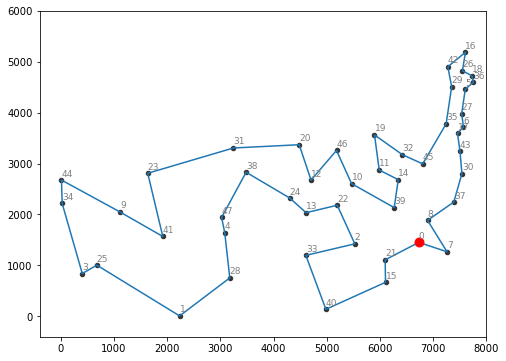

In [166]:
path = two_opt_loop(path)
sc = score(path + [path[0]])

while True:
    path = two_opt_loop(path)
    tmp = score(path + [path[0]])
    if sc == tmp:
        break
    sc = tmp

tour = path + [path[0]]
draw_plot(tour)
print(score(tour) / score(T))

# LP: case three
### Control Zone

Optimal


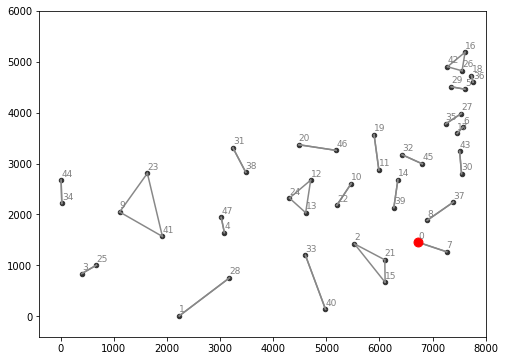

In [764]:
prob = LpProblem(name='TSP_LP', sense=LpMinimize)

dist = {(i, j): abs(XY[i] - XY[j]) for i in range(num) for j in range(num) if i != j}
x = LpVariable.dicts('x', dist, 0, 1, LpBinary)
#x = LpVariable.dicts('x', dist, 0, 1)

prob += lpSum([dist[(i, j)] * x[(i, j)] for i, j in dist])

for n in range(num):
    prob += lpSum([x[(i, j)] for i, j in dist if n in (i, j)]) == 2
    
res = prob.solve()
print(LpStatus[res])
ED = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
draw_plot(False, ED)

Optimal


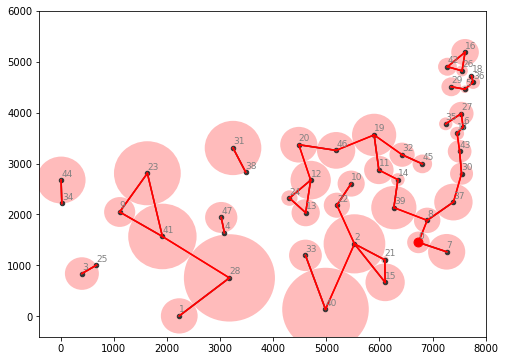

In [771]:
# First Packing
prob_m = LpProblem(name='TSP_DISK', sense=LpMaximize)
R = [LpVariable('R' + str(i), lowBound=0) for i in range(num)]
prob_m += lpSum(2 * R)
for i, j in dist:
    prob_m += R[i] + R[j] <= dist[(i, j)]
result = prob_m.solve()
print(LpStatus[result])

R = [value(R[i]) for i in range(num)]
ER = find_edges(R)
draw_plot(False, ED, ER, R, TX=True, size=(8, 6))

In [772]:
ST = find_subtour(ER)
ST2 = []
for st in ST:
    print(len(st), st)
    if len(st) <= num:
        ST2.append(st)
print('\nST2:', ST2)
print('\nST_flat:', set(sum(ST2, [])))

2 [(3, 25), (25, 3)]
2 [(4, 47), (47, 4)]
2 [(31, 38), (38, 31)]
2 [(34, 44), (44, 34)]
6 [(5, 29), (5, 36), (18, 36), (29, 5), (36, 5), (36, 18)]
6 [(16, 26), (16, 42), (26, 16), (26, 42), (42, 16), (42, 26)]
10 [(1, 28), (9, 23), (9, 41), (23, 9), (23, 41), (28, 1), (28, 41), (41, 9), (41, 23), (41, 28)]
14 [(2, 15), (2, 21), (2, 22), (2, 40), (10, 22), (15, 2), (15, 21), (21, 2), (21, 15), (22, 2), (22, 10), (33, 40), (40, 2), (40, 33)]
42 [(0, 7), (0, 8), (6, 17), (6, 27), (7, 0), (8, 0), (8, 37), (8, 39), (11, 14), (11, 19), (12, 13), (12, 20), (12, 24), (13, 12), (13, 24), (14, 11), (14, 39), (17, 6), (17, 43), (19, 11), (19, 32), (19, 46), (20, 12), (20, 46), (24, 12), (24, 13), (27, 6), (27, 35), (30, 37), (30, 43), (32, 19), (32, 45), (35, 27), (37, 8), (37, 30), (39, 8), (39, 14), (43, 17), (43, 30), (45, 32), (46, 19), (46, 20)]

ST2: [[(3, 25), (25, 3)], [(4, 47), (47, 4)], [(31, 38), (38, 31)], [(34, 44), (44, 34)], [(5, 29), (5, 36), (18, 36), (29, 5), (36, 5), (36, 18)],

Optimal


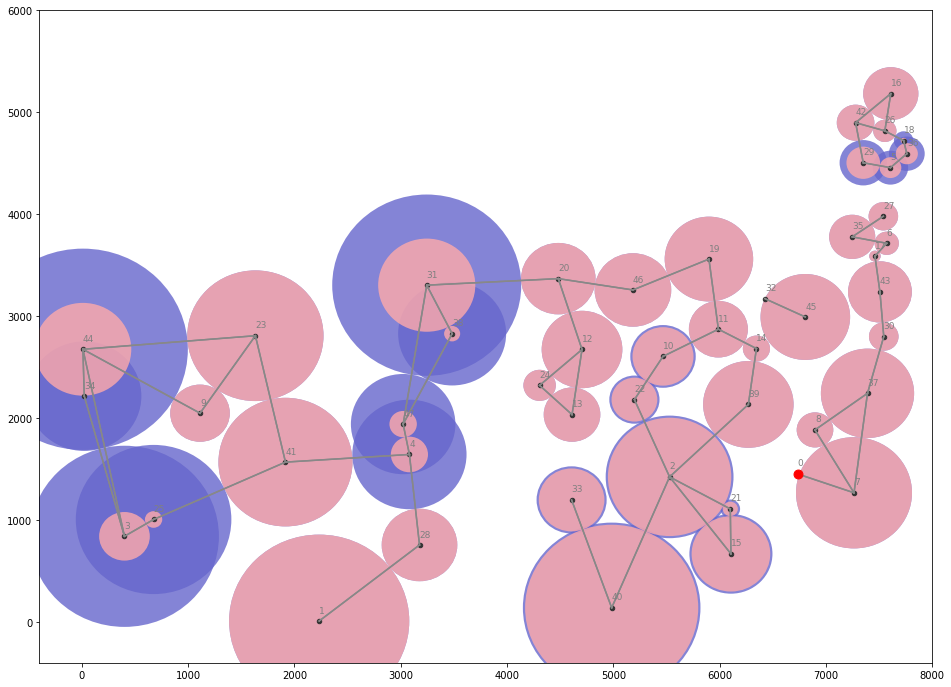

In [773]:
# partially working
prob_m = LpProblem(name='TSP_DISK', sense=LpMaximize)
R = [LpVariable('R' + str(i), lowBound=0) for i in range(num)]
M = [LpVariable('M' + str(i), lowBound=0) for i in range(len(ST2))]
prob_m += lpSum(2*R + 2*M)

def st_index(ST, n):
    for st in ST:
        st_flat = set(sum(st, ()))
        if n in st_flat:
            return ST.index(st)
        
ST_flat = sum(ST2, [])
ST_ff = set(sum(ST_flat, ()))
for i, j in dist:
    if i in ST_ff and j not in ST_ff:
        prob_m += R[i] + R[j] + M[st_index(ST2, i)] <= dist[(i, j)]
    elif i not in ST_ff and j in ST_ff:
        prob_m += R[i] + R[j] + M[st_index(ST2, j)] <= dist[(i, j)]
    elif i in ST_ff and j in ST_ff and st_index(ST2, i) != st_index(ST2, j):
        prob_m += R[i] + R[j] + M[st_index(ST2, i)] + M[st_index(ST2, j)] <= dist[(i, j)]
    else:
        prob_m += R[i] + R[j] <= dist[(i, j)]
        
result = prob_m.solve()
print(LpStatus[result])
R = [value(R[i]) for i in range(num)]
M = [value(M[i]) for i in range(len(ST2))]
RM = [R[i] + M[st_index(ST2, i)] if i in ST_ff else R[i] for i in range(num)]

def find_edges(R):
    ED = []
    for i, j in dist:
        diff = dist[(i, j)] - (R[i] + R[j])
        if diff < 1e-4:
            ED.append((i, j))
    return ED

ER = find_edges(RM)
draw_plot(False, ER, False, R, RM, size=(16, 12))

In [775]:
ST3 = find_subtour(ER)
for st in ST3:
    print(len(st), st)

2 [(32, 45), (45, 32)]
16 [(5, 29), (5, 36), (16, 26), (16, 42), (18, 26), (18, 36), (26, 16), (26, 18), (26, 42), (29, 5), (29, 42), (36, 5), (36, 18), (42, 16), (42, 26), (42, 29)]
20 [(0, 7), (6, 17), (6, 35), (7, 0), (7, 8), (7, 37), (8, 7), (8, 37), (17, 6), (17, 43), (27, 35), (30, 37), (30, 43), (35, 6), (35, 27), (37, 7), (37, 8), (37, 30), (43, 17), (43, 30)]


Optimal


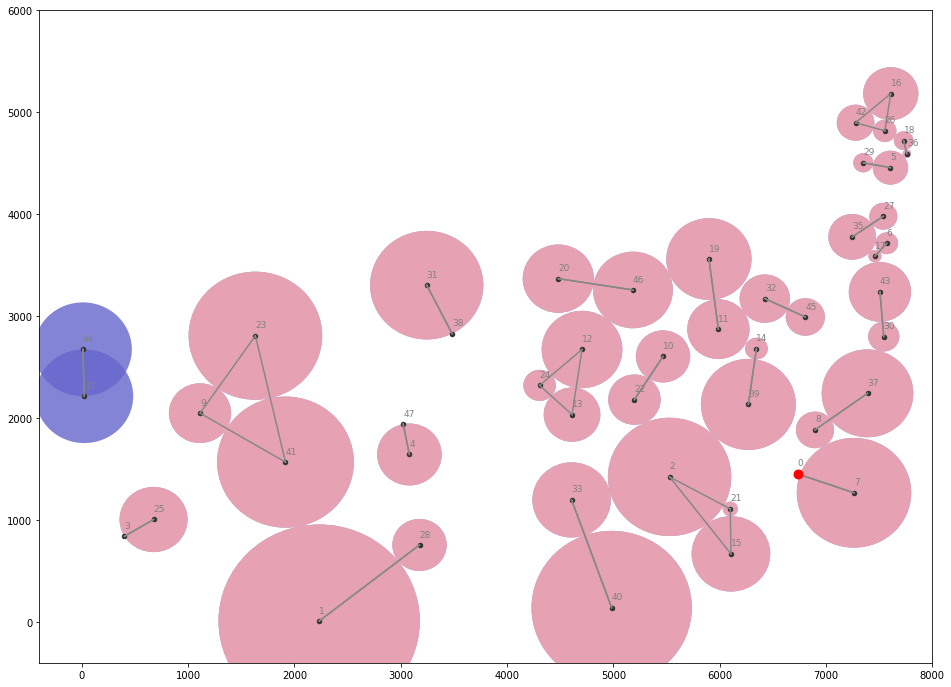

In [592]:
# OLD
def st_index(ST, n):
    for st in ST:
        st_flat = set(sum(st, ()))
        if n in st_flat:
            return ST.index(st)

prob_m = LpProblem(name='TSP_DISK', sense=LpMaximize)
R = [LpVariable('R' + str(i), lowBound=0) for i in range(num)]
M = [LpVariable('M' + str(i), lowBound=0) for i in range(len(ST))]
prob_m += lpSum(2*R + 2*M)

for i, j in dist:
    if (i, j) in ED:
        prob_m += R[i] + R[j] <= dist[(i, j)]

for st in ST:
    st_flat = set(sum(st, ()))
    nots = [n for n in range(num) if n not in st_flat]
    if len(st_flat) < num / 2:
        for s in st_flat:
            for n in nots:
                prob_m += R[s] + R[n] + M[ST.index(st)] <= dist[(s, n)]
            
result = prob_m.solve()
print(LpStatus[result])

R = [value(R[i]) for i in range(num)]
M = [value(M[i]) for i in range(len(ST))]
RM = [R[i] + M[st_index(ST, i)] for i in range(num)]
draw_plot(False, ED, False, R, RM, TX=True, size=(8*2, 6*2)) 

In [ ]:
# old
prob_m = LpProblem(name='TSP_DISK', sense=LpMaximize)
R = [LpVariable('R' + str(i), lowBound=0) for i in range(num)]
#M = [LpVariable('M' + str(i), lowBound=0) for i in range(len(ST2))]

prob_m += lpSum(2 * R + 2 * M)

for i, j in dist:
    if (i, j) in ST2_flat:
        prob_m += R[i] + R[j] <= dist[(i, j)]    
    else:
        prob_m += R[i] + R[j] <= dist[(i, j)]

#for i, j in dist:
#    prob_m += R[i] + R[j] + M <= dist[(i, j)]

result = prob_m.solve()
print(LpStatus[result])

R = [value(R[i]) for i in range(num)]
M = [value(M[i]) for i in range(len(ST))]
    

draw_plot(False, ED, False, R, TX=True, size=(16, 12))

# Control Zone

In [288]:
# Base Disks
def base_disks():
    prob = LpProblem(name='TSP_DISK', sense=LpMaximize)
    R = [LpVariable('R' + str(i), lowBound=0) for i in range(num)]
    M = [LpVariable('M' + str(i), lowBound=0) for i in range(num)]
    prob += lpSum(2 * R + 2 * M)

    for i, j in dist:
        prob += R[i] + R[j] + M[i] <= dist[(i, j)]
        prob += R[i] + R[j] + M[j] <= dist[(i, j)]
    
    result = prob.solve()
    print(LpStatus[result])
    #R = [value(R[i]) + value(M[i]) for i in range(num)]
    R = [value(R[i]) for i in range(num)]
    M = [value(M[i]) for i in range(num)]
    return R, M

R, M = base_disks()

Optimal


In [289]:
# find edges from disk packing
def find_edges(R):
    ED = []
    for i, j in dist:
        diff = dist[(i, j)] - (R[i] + R[j])
        if diff < 1e-4:
            ED.append((i, j))
    return ED

ED = find_edges(R)

204

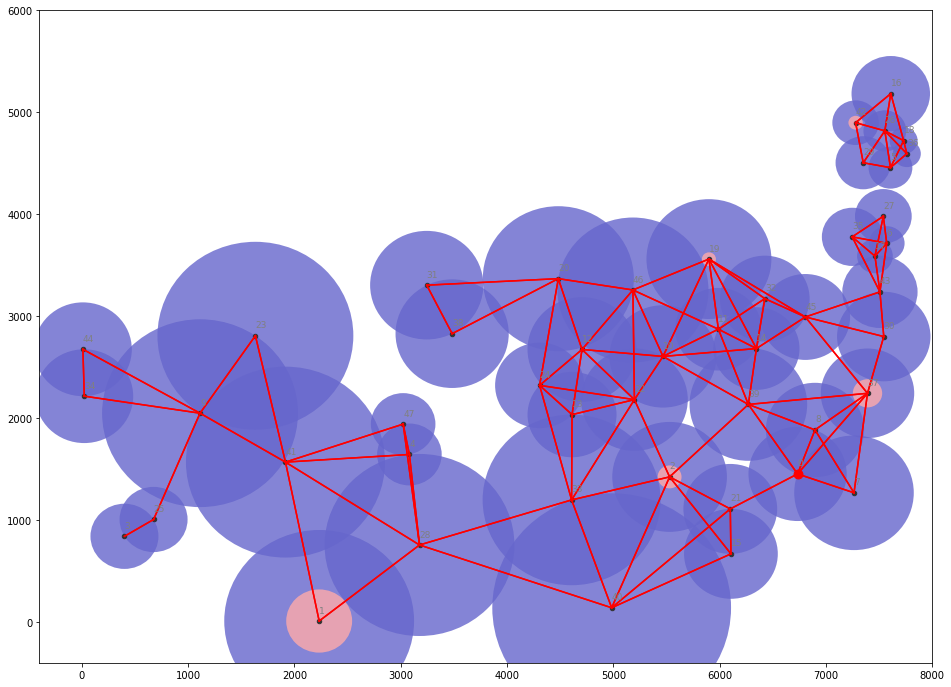

In [292]:
RM = [R[i] + M[i] for i in range(num)]
EM = find_edges(RM)
# Result: first packing
draw_plot(False, ED, EM, R, M, TX=True, size=(8*2, 6*2))
len(EM)

In [7]:
# Edge Grouping: return ST 
def gen_subtour(ED):
    EG = []
    for e in ED:
        st = [e]
        while True:
            tmp = st.copy()
            for ee in ED:
                if set(sum(st, ())) & set(ee) and ee not in st:
                    st += [ee]
            if tmp == st:
                break
        if sorted(st) not in EG:
            EG.append(sorted(st))

    ST = []
    for i in range(num):
        for e in EG:
            if i == len(e):
                ST.append(e)
    return ST

ST = gen_subtour(ED)
for st in ST:
    print(len(st), st)    

1 [(3, 25)]
1 [(4, 47)]
1 [(31, 38)]
1 [(34, 44)]
3 [(5, 29), (5, 36), (18, 36)]
3 [(16, 26), (16, 42), (26, 42)]
5 [(1, 28), (9, 23), (9, 41), (23, 41), (28, 41)]
7 [(2, 15), (2, 21), (2, 22), (2, 40), (10, 22), (15, 21), (33, 40)]
21 [(0, 7), (0, 8), (6, 17), (6, 27), (8, 37), (8, 39), (11, 14), (11, 19), (12, 13), (12, 20), (12, 24), (13, 24), (14, 39), (17, 43), (19, 32), (19, 46), (20, 46), (27, 35), (30, 37), (30, 43), (32, 45)]


In [ ]:
# OLD one by one moating 
def moats(R, ST, st_num):
    if len(ST[st_num]) < num / 2:
        prob_m = LpProblem(name='TSP_DISK_M' + str(stm_num), sense=LpMaximize)
    
        st_flat = set(sum(ST[st_num], ()))
        M = LpVariable('M', lowBound=0)
        prob_m += M

        nots = [n for n in range(num) if n not in st_flat]
        for s in st_flat:
            for n in nots:
                if s < n:
                    prob_m += R[s] + R[n] + M <= dist[(s, n)]
                elif n < s:
                    prob_m += R[n] + R[s] + M <= dist[(n, s)]

        res = prob_m.solve()
        print(LpStatus[res])
        RM = [R[i] + value(M) if i in st_flat else R[i] for i in range(num)]
        return RM
    else:
        return R

In [48]:
# NEW: one by one moating
def moat(R, ST):
    for st in ST:
        if len(st) < num / 2:
            prob_m = LpProblem(name='TSP_DISK_M', sense=LpMaximize)

            st_flat = set(sum(st, ()))
            M = LpVariable('M', lowBound=0)
            prob_m += M

            nots = [n for n in range(num) if n not in st_flat]
            for s in st_flat:
                for n in nots:
                    if s < n:
                        prob_m += R[s] + R[n] + M <= dist[(s, n)]
                    elif n < s:
                        prob_m += R[n] + R[s] + M <= dist[(n, s)]

            res = prob_m.solve()
            print(LpStatus[res])
            R = [R[i] + value(M) if i in st_flat else R[i] for i in range(num)]
            break
    return R

RM = moats2(R, ST)

In [13]:
def find_edges(R):
    ED = []
    for i, j in dist:
        diff = dist[(i, j)] - (R[i] + R[j])
        if diff < 1e-4:
            ED.append((i, j))
    return ED

EDN = list(set(find_edges(RM)) - set(ED))

In [ ]:
draw_plot(False, ED, EDN, R, RM, TX=True, size=(8*2, 6*2))

## START

Optimal
[(3, 25)]
[(4, 47)]
[(31, 38)]
[(34, 44)]
[(5, 29), (5, 36), (18, 36)]
[(16, 26), (16, 42), (26, 42)]
[(1, 28), (9, 23), (9, 41), (23, 41), (28, 41)]
[(2, 15), (2, 21), (2, 22), (2, 40), (10, 22), (15, 21), (33, 40)]
[(0, 7), (0, 8), (6, 17), (6, 27), (8, 37), (8, 39), (11, 14), (11, 19), (12, 13), (12, 20), (12, 24), (13, 24), (14, 39), (17, 43), (19, 32), (19, 46), (20, 46), (27, 35), (30, 37), (30, 43), (32, 45)]


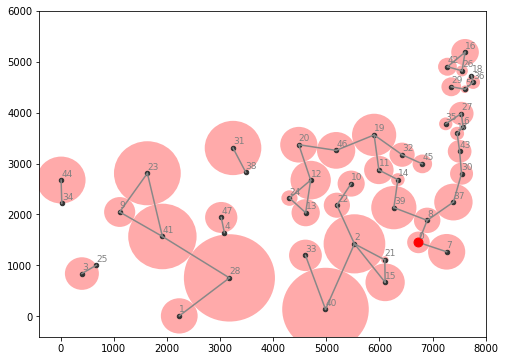

In [52]:
R = base_disks()
ED = find_edges(R)
draw_plot(False, ED, False, R, RM=False, TX=True, size=(8, 6))
ST = gen_subtour(ED)
#STM = subtour_m(ST)
for s in ST:
    print(s)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


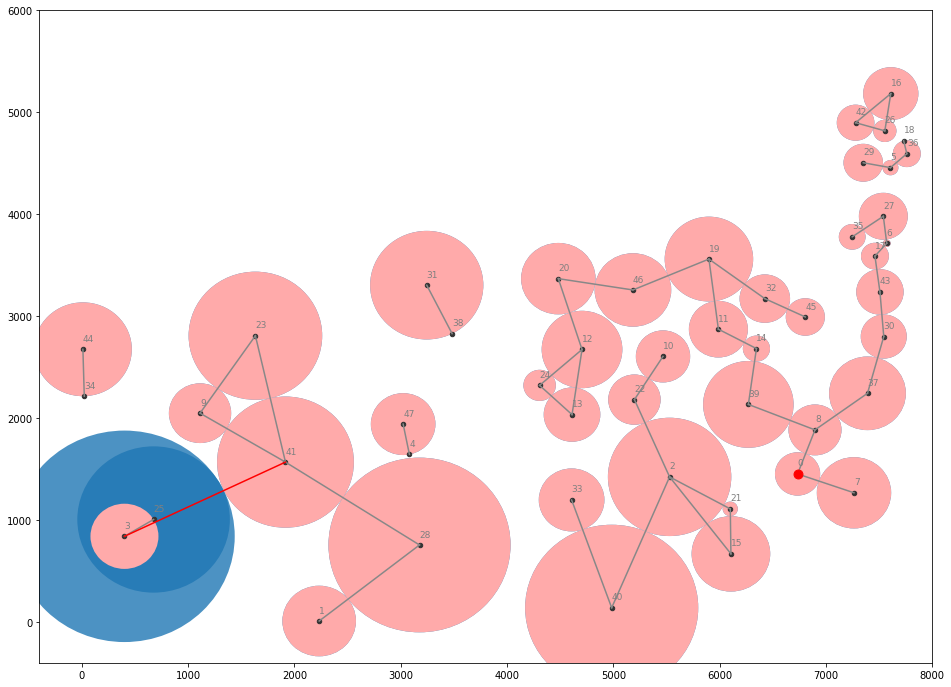

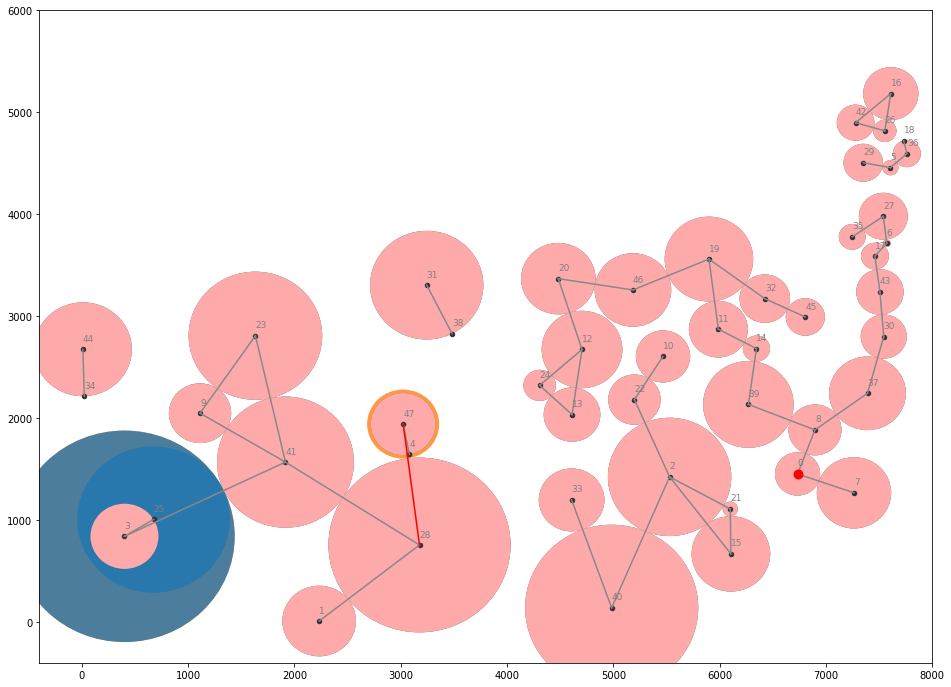

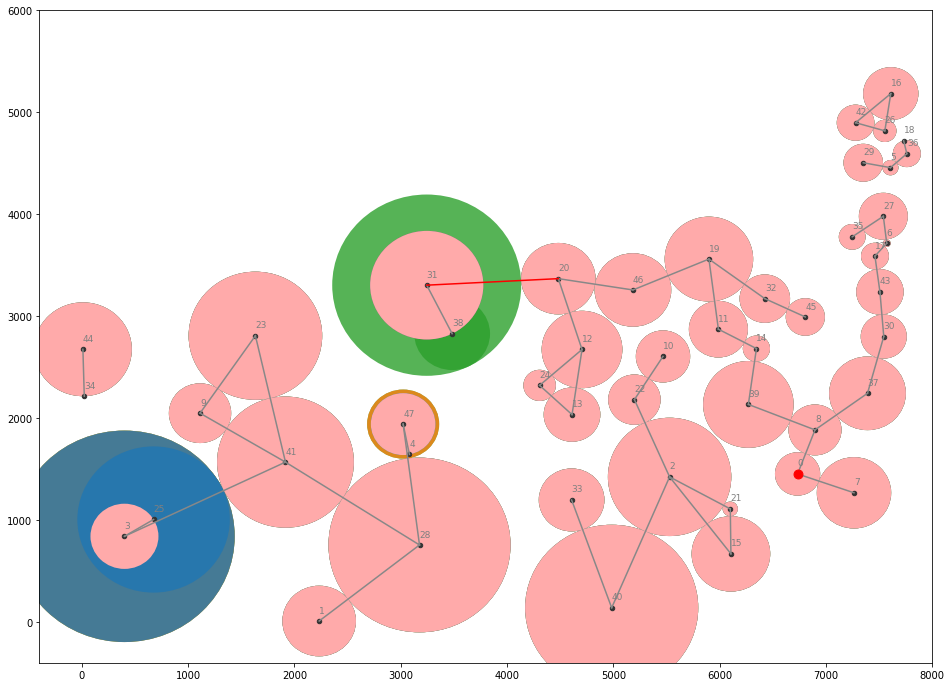

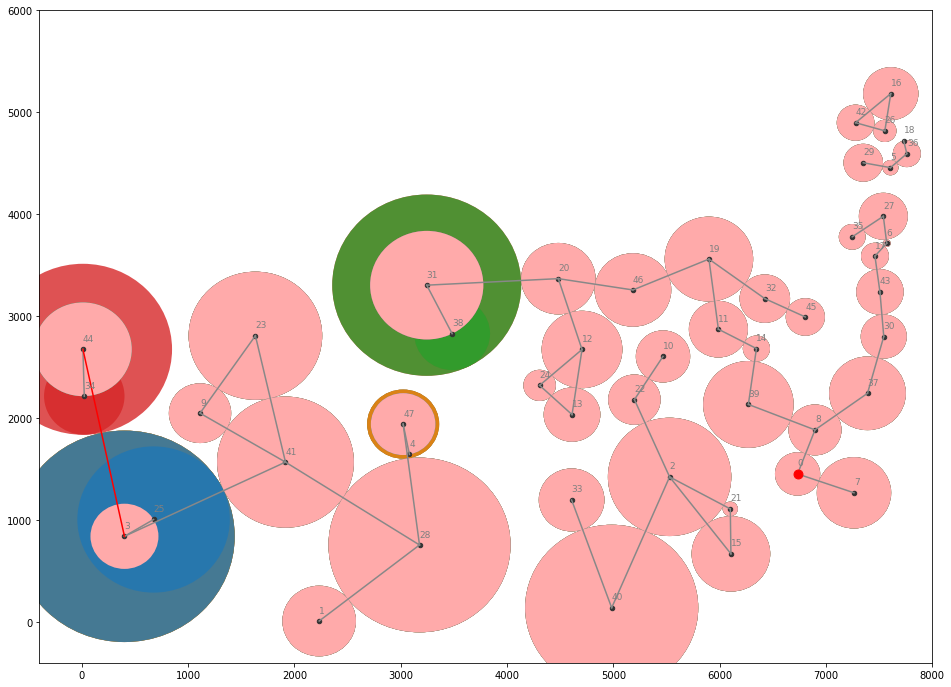

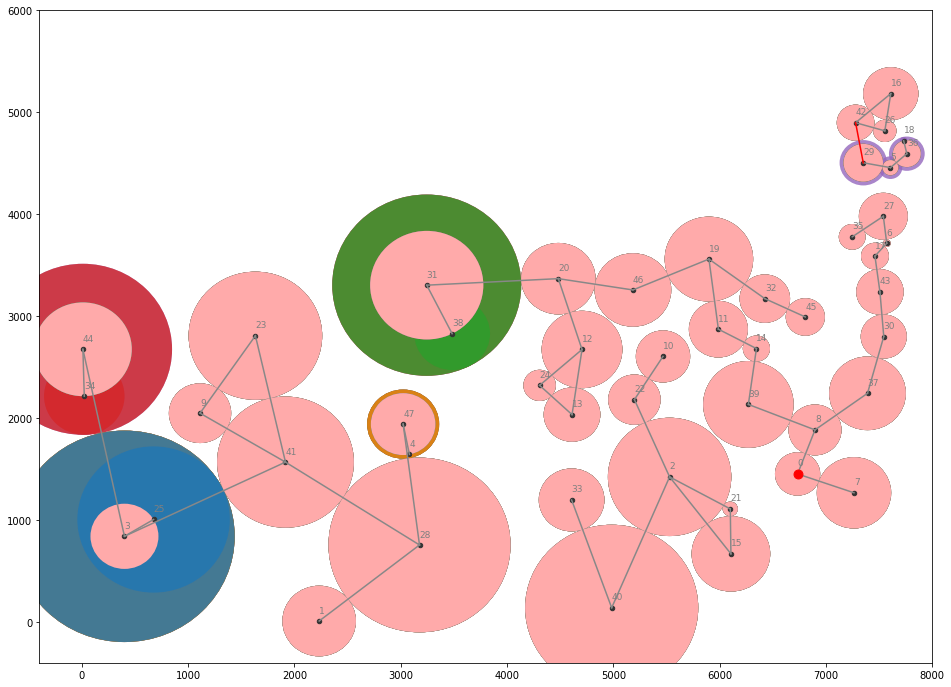

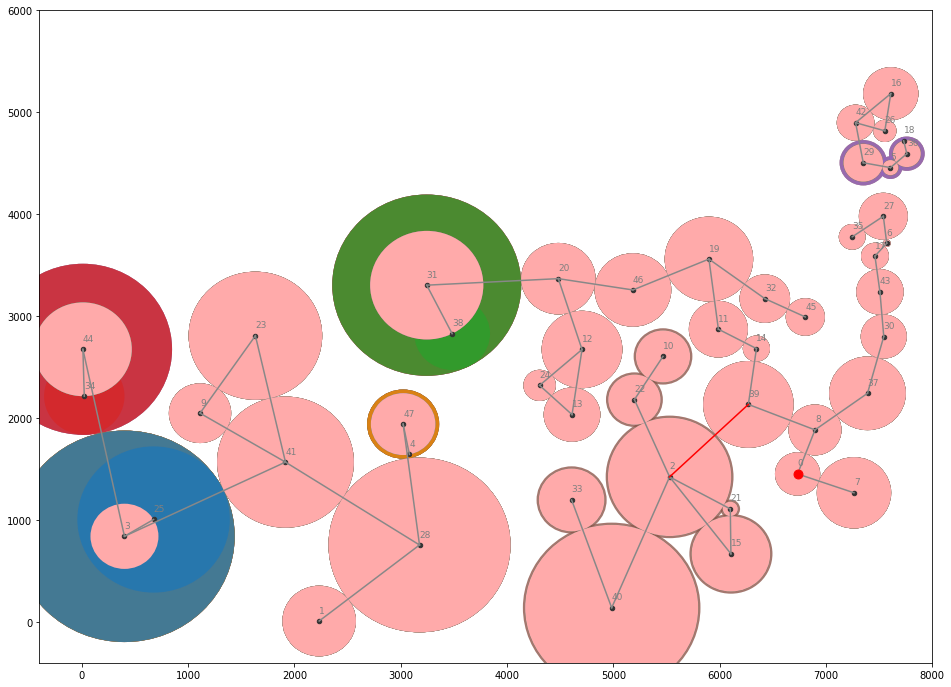

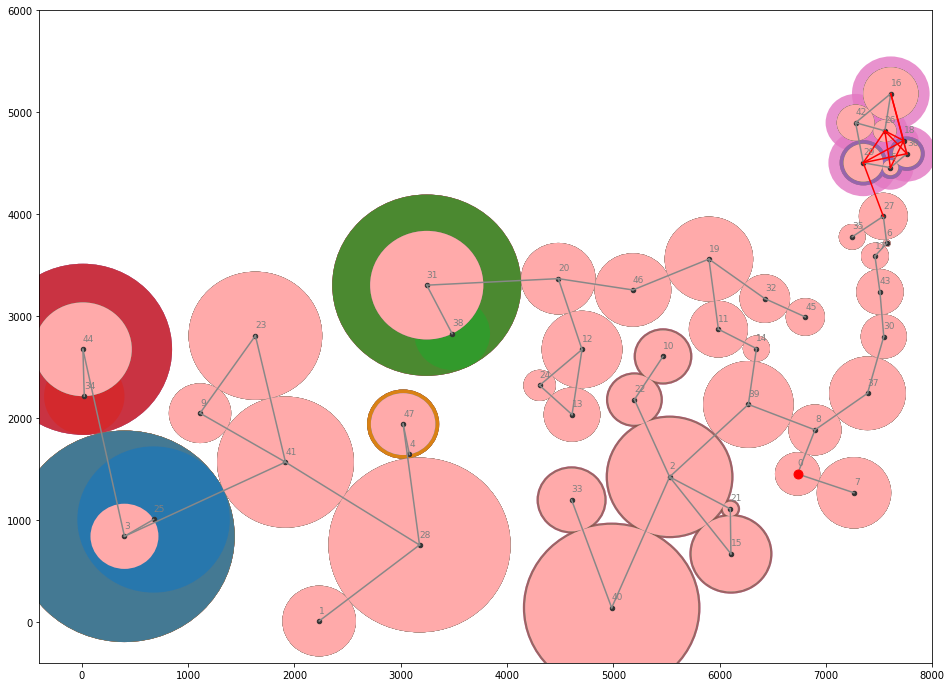

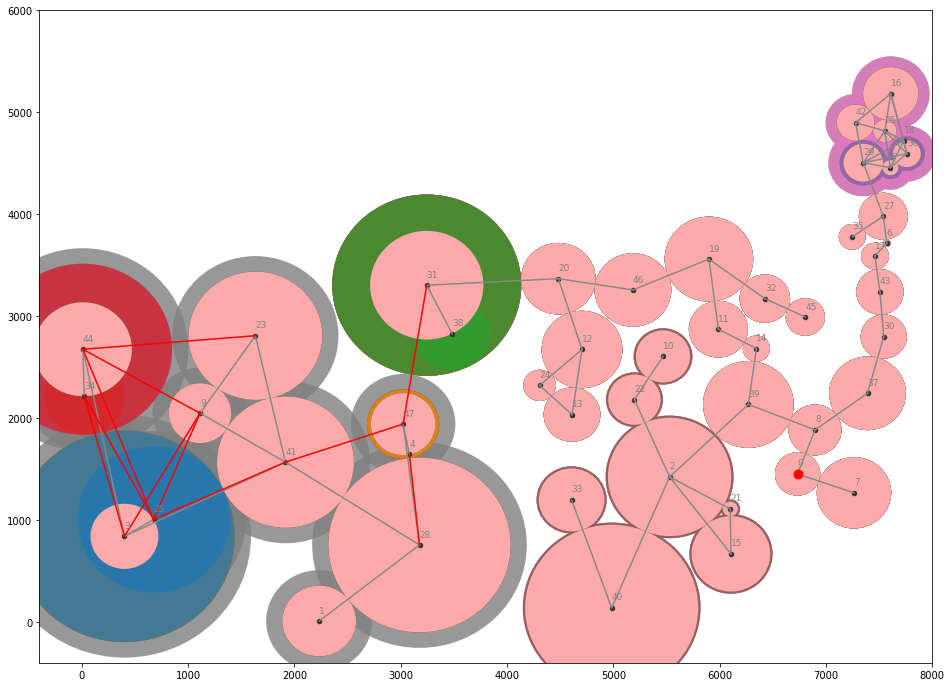

In [53]:
MM = []
R1 = R.copy()
while len(ST) > 0:
    RM = moat(R, ST)
    ED2 = find_edges(RM)
    EDN = list(set(ED2) - set(ED))
    MM.append(RM)
    draw_plot(False, ED, EDN, R1, False, MM, TX=True, size=(8*2, 6*2))
    R = RM.copy()
    ED = ED2.copy()
    ST = gen_subtour(ED)

#draw_plot(False, ED, EDN, R1, False, MM, TX=True, size=(8*2, 6*2))

In [428]:
a = np.arange(10000*10000, dtype=np.int32)

In [702]:
198/12

16.5